##  Optimze and a Dense Neural Network for gap filling and feature identification

** With a few tweaks to RepRunner, an LSTM can be run instead

In [1]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
# from functools import partial
from multiprocessing import Pool
from functools import partial
from sklearn import metrics
import ipywidgets as widgets
from ipywidgets import Layout
from IPython.display import clear_output
# from sklearn.model_selection import train_test_split

## Personal Modules
import ReadStandardTimeFill as RSTF
import importlib
import DenseNet as Dense
import MiscFuncs as MF
importlib.reload(Dense)
importlib.reload(RSTF)
importlib.reload(MF)

# %matplotlib inline

%matplotlib notebook
%config IPCompleter.greedy=True

from scipy.optimize import minimize, curve_fit
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
from sklearn.externals import joblib
from matplotlib import cm

from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

from ipywidgets import FloatProgress
from IPython.display import display
import os  
import shutil
from keras import backend as K
try:pool.close()
except:pass

def t(p,n):
    alpha = 1-p
    df = n-1
    return(stats.t.ppf(alpha,df))


# FirstRun = True
# FirstRun = False
aliases={'wind_speed':'$\overline{U}$','PPFD_Avg':'PPFD',
        'AirTC_Avg':'T$_{a}$','Out_of_Basin':'F$_{out}$','Upland':'F$_{up}$',
        'Sedge':'F$_{sdg}$','air_pressure':'P$_{a}$',
        'Shrub':'F$_{shb}$','Sparse':'F$_{spr}$','Grass':'F$_{grs}$'
         ,'Temp':'T$_{s}$','H':'$H$','VPD':'$VPD$','VWC':'$VWC$',
        'Water Table': 'W$_{TBL}$','Active Layer':'AL',
        'Wind Spd':'$\overline{U}$','24H Rain':'24HR','Wtr Tbl Trnd':'d Wtr Tbl',
        'air pressure':'P$_{a}$','Ta':'T$_{a}$','Rn':'Rn','PPFD':'PPFD','Rain':'Rain',
        'Ts 2.5 cm':'T$_{2.5cm}$','Ts 15 cm':'T$_{15cm}$','(z-d)/L':'Stability'}

pd.set_option('max_colwidth',200)
MP=True

cwd = os.getcwd()
Site='Illisarvik'

C:\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
class ResultMap:
    def __init__(self,target,SE_Rule=1):
        self.SE_Rule = SE_Rule
        self.target = target
        self.target_name = target
        if target == 'fco2_Final':
            self.target = 'fco2'
            self.target_name = 'fco2'
        if target == 'fch4_Final':
            self.target = 'fch4'
            self.target_name = 'fch4'
        self.params = Dense.Params('Full',self.target,MP)
        self.params['Dpath'] = cwd+'/'+Site+'/'
        self.RST = RSTF.ReadStandardTimeFill(self.params,'ECData.csv')#,resample='2H')
        self.Records = pd.read_csv(self.params['Dpath']+'/'+target+'_Runs.csv',delimiter = ',',header = 0,index_col=[0])
        self.Records['Model_Key']=self.Records['Size'].astype(str)+'_'+self.Records['Number'].astype(str)

        Names = []
        rem = []
        for level in self.Records['Size'].unique():
            Level = self.Records.loc[self.Records['Size']==level]
#             print(Level)
            if level == 1:
                level_best = Level.loc[Level['MSE']==Level['MSE'].min()]
                LastMod=[level_best['Model'].values[0]]
                Names.append(aliases[LastMod[0]])
            elif level == 99:
                level_best = Level.loc[Level['MSE']==Level['MSE'].min()]
                LastMod=[level_best['Model'].values[0]]
                Names.append('N/A')
                
            else:
                level_best = level_best.append(Level.loc[Level['MSE']==Level['MSE'].min()])
                Mod = level_best.loc[level_best['Size']==level,'Model'].values[0].split('+')

        self.Min = self.Records.loc[self.Records['MSE']==self.Records['MSE'].min()]
        Best = level_best.loc[level_best['Performance']==2]
        print(Best)
        try:
            self.Best = Best.loc[Best['Size']==Best['Size'].max()]
    #         self.Model_Selection = self.Best.copy()
            self.Model_Selection = self.Best['Model'].values[0]
        except:
            self.Model_Selection = self.Min['Model'].values[0]
            pass
        self.level_best = level_best
            
        
    def Project(self,Projector = None,Model = None):
        if Model ==  None:
            self.Model = self.Model_Selection
        else:
            self.Model = Model
        idx = self.Records['Model_Key'].loc[self.Records['Model']==self.Model].values[0]
#         idx = '99_99'
        self.params['Spath']=(self.params['Dpath']+'/'+self.target_name+'/'+idx+'/')
        self.params['Inputs'] = self.Model.split('+')
        self.RST.Scale(self.params['target'],self.params['Inputs'],ScalePath=self.params['Spath'])
        if Projector != None:
            if Projector['Map'] == None:
                for ip,val in zip(Projector['Assign']['input'],Projector['Assign']['value']):                    
                    self.RST.Data[ip] = val
            else:
                for ip in self.params['Inputs']:
                    self.RST.Data[ip] = self.RST.Data[ip].mean()
                for ip,val in zip(Projector['Map']['input'],Projector['Map']['min'],Projector['Map']['max']):                    
                    self.RST.Data[ip] = val
                
            self.RST.Scale(self.params['target'],self.params['Inputs'],ScalePath=self.params['Spath'],Project=True)
            
    def Map(self,Fill=False,Map=True):
        if Fill == True:
            X = self.RST.X_fill
        else:
            X = self.RST.X
        self.params['Sname']='Y_'
        Y_fill = []
        MSE = []
        if __name__ == "__main__":
            pool = Pool(processes=3,maxtasksperchild=75)
            for k,results in enumerate(pool.imap(partial(Dense.Load_Model,X=X,params=self.params),range(self.params['K']))):
                Y = results
                Yold = Y+0
                Y = self.RST.YScaled.inverse_transform(Y)
                if Fill == False and Map == False:
                    mse = (metrics.mean_squared_error(self.RST.y,Y))
                    MSE.append(mse)
                Y_fill.append(Y)
        
            pool.close()
        Y_fill = np.asanyarray(Y_fill).mean(axis=-1)
        Y_fill_bar = Y_fill.mean(axis=0)
#         plt.figure()
        YTru = self.RST.y+0.0
#         plt.scatter(Y_fill_bar,self.RST.y)
        if Fill == False and Map == False:
            self.MSE = np.asanyarray(MSE)
            self.CI = stats.t.ppf(1-0.025,k)*self.MSE.std()/(k)**.5
        
        YStandard = joblib.load(self.params['Spath']+"YVar_scaler.save") 
        self.params['Sname']='Var'
        self.params['Loss']='Boot_Loss'
        pool = Pool(processes=1,maxtasksperchild=75)
        for k,results in enumerate(pool.imap(partial(Dense.Load_Model,X=X,params=self.params),range(1,2))):
            YVar = results
            YVar = self.RST.YvarScaled.inverse_transform(YVar)                    
        pool.close()
        X_back = np.squeeze(self.RST.XScaled.inverse_transform(X))
        
        self.Data_Map = pd.DataFrame(data=X_back,columns=self.params['Inputs'])
        self.Data_Map[self.target] = np.squeeze(Y_fill_bar)
        if Map == False:
            self.Data_Map['True'] = YTru
        self.Data_Map['Var_reg'] = 1/(self.params['K']-1)*((Y_fill-Y_fill_bar)**2).sum(axis=0)
        self.Data_Map['Var_er'] = np.squeeze(YVar)
        self.Data_Map['SE'] = self.Data_Map['Var_reg']**.5
        self.T = stats.t.ppf(1-0.025,self.params['K'])
        self.Data_Map['CI']=self.T*self.Data_Map['SE']
        self.Data_Map['PI']=self.T*((self.Data_Map['Var_er']+self.Data_Map['Var_reg'])**.5) 

class Display:
    def __init__(self,targets,target_names):
    
        self.target_options={}
        self.target_names=target_names
        for target,name in zip(targets,target_names):
            self.target_options[name]=target
        self.i = 0
        self.Reset('b')
        
    def Reset(self,b):
        button2 = widgets.Button(description="Reset")
        display(button2)
        button2.on_click(self.Clear) 
        self.Select('b')
            
        
    def Select(self,b):
        self.target = self.target_options[self.target_names[self.i]]
        print('Select Model for: ',self.target_names[self.i])
        self.size = widgets.IntSlider(
            value=self.target.Best['Size'].values[0],
            min=1,
            max=self.target.level_best['Size'].max(),
            step=1,
            description='Model Size:',
            continuous_update=True,
            orientation='horizontal',
            readout=True,
            readout_format='d'
        )
        display(self.size)
        button = widgets.Button(description="Query Models")
        display(button)
        button.on_click(self.Select_Models) 
    
    def Clear(self,b):
        clear_output()
        self.i = 0
        self.Reset('b')
        
    def Select_Models(self,b):
        self.Model_Selection = widgets.Select(
        options=self.target.Records.loc[self.target.Records['Size']==self.size.value,'Model'].values,
        value=self.target.level_best.loc[self.target.level_best['Size']==self.size.value,'Model'].values[0],
        # rows=10,
        layout=Layout(width='100%'),
        description='Model:',
        disabled=False
        )
        display(self.Model_Selection)
               
        button = widgets.Button(description="Analyze This Model")
        display(button)
        button.on_click(self.Choose)
        
    def Choose(self,b):
        self.target.Model_Selection = self.Model_Selection.value
        self.i +=1
        if self.i < len(self.target_names):
            self.Select('b')



In [10]:

fco2 = ResultMap('fco2')
fch4 = ResultMap('fch4')
fco2_final = ResultMap('fco2_Final')
fch4_final = ResultMap('fch4_Final')
fco2_final.Model_Selection=fco2_final.Records['Model'].values[0]
fch4_final.Model_Selection=fch4_final.Records['Model'].values[0]
# print(fco2_final.Model_Selection)
# fch4_final = ResultMap('Final')
# # fco2.Project()
# # print(fco2.RST.Master['ER'].shape)
# # print(fco2.RST.Data['ER'].shape)
# # print(ER.Records)
Disp = Display([fco2,fch4],['fco2','fch4'])
# fco2 = Disp.target_options['fco2']
# fch4 = Disp.target_options['fch4']


                     Model       MSE  Size  Number        SE  Performance  \
14            PPFD_Avg+VPD  0.044388     2       3  0.003667            2   
39  PPFD_Avg+AirTC_Avg+VWC  0.034212     3      18  0.005005            2   
63  PPFD_Avg+VPD+VWC+Shrub  0.031771     4      12  0.003593            2   

      T        T2 Model_Key  
14  0.0 -2.939041       2_3  
39  0.0 -8.982760      3_18  
63  0.0 -2.169622      4_12  
                                  Model       MSE  Size  Number        SE  \
23                            VWC+Sedge  0.278078     2      12  0.037043   
35                       Temp+VWC+Sedge  0.250437     3       5  0.039969   
45           wind_speed+VWC+Sedge+Grass  0.222317     4       6  0.036494   
86  wind_speed+PPFD_Avg+VWC+Sedge+Grass  0.193102     5      11  0.024433   

    Performance    T         T2 Model_Key  
23            2  0.0 -12.084587      2_12  
35            2  0.0  -2.778214       3_5  
45            2  0.0  -2.845667       4_6  
86       

A Jupyter Widget

Select Model for:  fco2


A Jupyter Widget

A Jupyter Widget

In [9]:
print(fco2_final.Records)
print(fco2.Records.loc[fco2.Records['Size']==5].sort_values('MSE'))
# print(fch4_final.Records)

                                     Model       MSE  Size  Number        SE  \
99_99  PPFD_Avg+VPD+VWC+Shrub+Out_of_Basin  0.029957    99      99  0.004674   

       Performance Model_Key  
99_99            0     99_99  
                                Model       MSE  Size  Number        SE  \
66  wind_speed+PPFD_Avg+VPD+VWC+Shrub  0.030490     5       0  0.005715   
69        PPFD_Avg+VPD+Temp+VWC+Shrub  0.030649     5       3  0.004307   
68   PPFD_Avg+AirTC_Avg+VPD+VWC+Shrub  0.031077     5       2  0.004363   
72      PPFD_Avg+VPD+VWC+Shrub+Upland  0.031759     5       6  0.004300   
67     (z-d)/L+PPFD_Avg+VPD+VWC+Shrub  0.032212     5       1  0.005806   
70       PPFD_Avg+VPD+VWC+Sedge+Shrub  0.032703     5       4  0.004494   
71       PPFD_Avg+VPD+VWC+Shrub+Grass  0.032886     5       5  0.004052   

    Performance         T        T2 Model_Key  
66            1  0.000000 -1.039370       5_0  
69            1  0.121457 -1.095953       5_3  
68            1  0.446945 -0.672

<IPython.core.display.Javascript object>


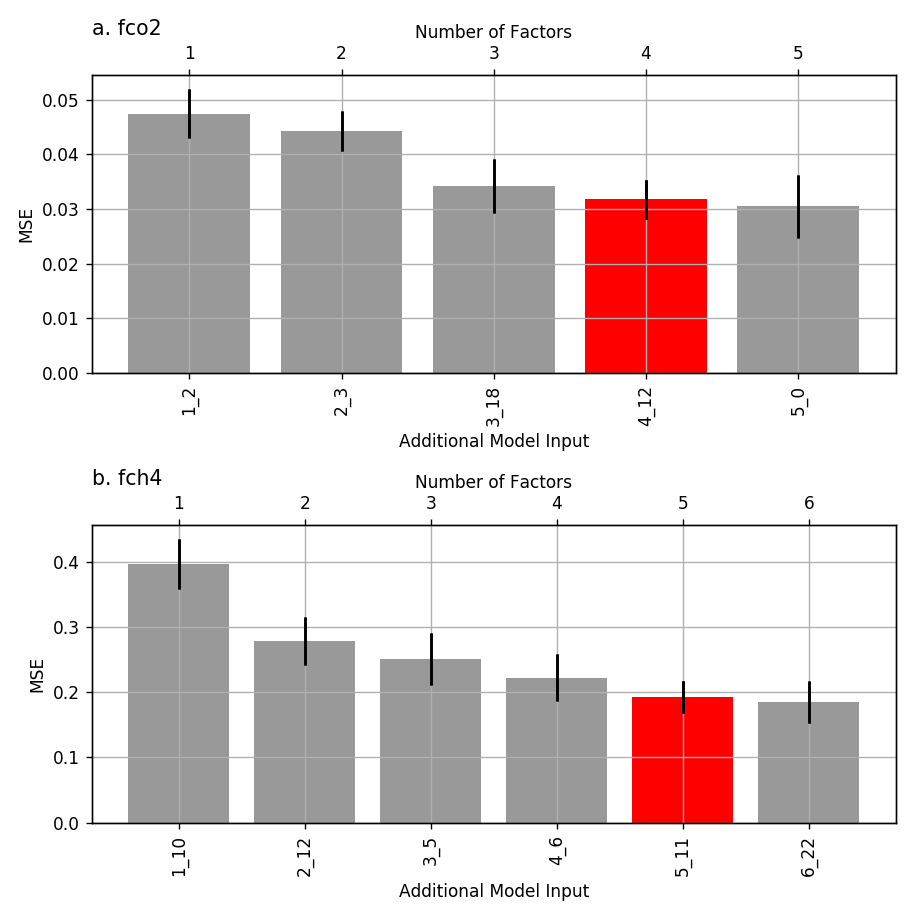

                                Model       MSE  Size  Number        SE  \
2                            PPFD_Avg  0.047491     1       2  0.004470   
14                       PPFD_Avg+VPD  0.044388     2       3  0.003667   
39             PPFD_Avg+AirTC_Avg+VWC  0.034212     3      18  0.005005   
63             PPFD_Avg+VPD+VWC+Shrub  0.031771     4      12  0.003593   
66  wind_speed+PPFD_Avg+VPD+VWC+Shrub  0.030490     5       0  0.005715   

    Performance    T        T2 Model_Key  
2             1  0.0  0.000000       1_2  
14            2  0.0 -2.939041       2_3  
39            2  0.0 -8.982760      3_18  
63            2  0.0 -2.169622      4_12  
66            1  0.0 -1.039370       5_0  
                                   Model       MSE  Size  Number        SE  \
10                                Upland  0.395989     1      10  0.038521   
23                             VWC+Sedge  0.278078     2      12  0.037043   
35                        Temp+VWC+Sedge  0.250437     3 

In [116]:
def Performance(ax,title,target):
    ax.bar(target.level_best['Size'].values,target.level_best['MSE'].values,
           yerr=target.level_best['SE'].values*target.SE_Rule,
           color='grey',
        alpha = .8,label='Best model at\neach size')
    ax.bar(target.Best['Size'].values,target.Best['MSE'].values,
           yerr=target.Best['SE'].values*target.SE_Rule,
           color='red',
           alpha = 1,
           label='Parsimony')
    yaxy = ax.twiny()
    yaxy.bar(target.level_best['Size'].values,target.level_best['MSE'].values,
             yerr=target.level_best['SE'].values*target.SE_Rule,
             color='grey',
             alpha = 0,label=None)
    yaxy.set_xlabel('Number of Factors')
    ax.set_ylabel('MSE')
    ax.set_xlabel('Additional Model Input')
    ax.set_title(title,y=1.1,loc='left')
    plt.sca(ax)
    plt.grid()
    plt.xticks(target.level_best['Size'],target.level_best['Model_Key'],rotation=90)
    print(target.level_best)

    
MP=False
Scope = 'Test'
cwd = os.getcwd()
# cwd = 'C:\\Users\\wesle\\Backup'
Site='Illisarvik'
Fill = False


fig,ax=plt.subplots(2,1,figsize=(7.5,7.5))
Performance(ax[0],'a. fco2',fco2)
Performance(ax[1],'b. fch4',fch4)
plt.tight_layout()


<IPython.core.display.Javascript object>


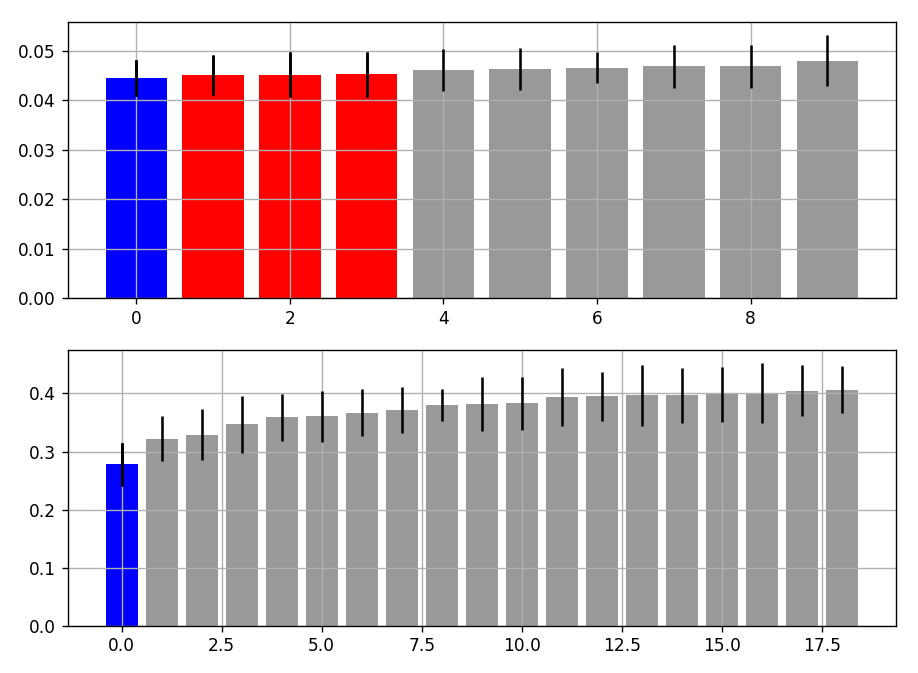

   index                Model       MSE  Size  Number        SE  Performance  \
0     14         PPFD_Avg+VPD  0.044388     2       3  0.003667            2   
1     16         PPFD_Avg+VWC  0.045078     2       5  0.004038            2   
2     11  wind_speed+PPFD_Avg  0.045144     2       0  0.004496            2   
3     12     (z-d)/L+PPFD_Avg  0.045200     2       1  0.004592            2   

          T        T2 Model_Key  
0  0.000000 -2.939041       2_3  
1  0.692835 -2.193651       2_5  
2  0.713469 -2.027479       2_0  
3  0.756332 -1.958211       2_1  

   index                Model       MSE  Size  Number        SE  Performance  \
0     14         PPFD_Avg+VPD  0.044388     2       3  0.003667            2   
1     16         PPFD_Avg+VWC  0.045078     2       5  0.004038            2   
2     11  wind_speed+PPFD_Avg  0.045144     2       0  0.004496            2   
3     12     (z-d)/L+PPFD_Avg  0.045200     2       1  0.004592            2   
4     18       PPFD_Avg+Shru

In [21]:
def LevelPerformance(ax,title,target,level=1,SE_Rule=1):
    Data = target.Records.loc[target.Records['Size']==level].sort_values('MSE').reset_index()
    
    if level == 1:
        Data['Name']=Data['Model']
        for val in Data['Model']:
            Data.loc[Data['Model']==val,'Name']=aliases[val]
        Min = Data[Data['MSE']==Data['MSE'].min()]
        Best = Data[Data['Performance']==1]
        ax.bar(Data['Name'],Data['MSE'].values,
               yerr=Data['SE'].values*target.SE_Rule,
               color='grey',
            alpha = .8,label='Best model at\neach size')
        ax.bar(Best['Name'],Best['MSE'].values,
               yerr=Best['SE'].values*target.SE_Rule,
               color='red',
               alpha = 1,
               label='Parsimony')
        ax.bar(Min['Name'],Min['MSE'].values,
               yerr=Min['SE'].values*target.SE_Rule,
               color='blue',
               alpha = 1,
               label='Parsimony')
        print(Best)
    else:
        Best = Data[Data['Performance']==2]
        Min = Data[Data['MSE']==Data['MSE'].min()]
        ax.bar(Data.index,Data['MSE'].values,
               yerr=Data['SE'].values*target.SE_Rule,
               color='grey',
            alpha = .8,label='Best model at\neach size')
        ax.bar(Best.index,Best['MSE'].values,
               yerr=Best['SE'].values*target.SE_Rule,
               color='red',
               alpha = 1,
               label='Parsimony')
        ax.bar(Min.index,Min['MSE'].values,
               yerr=Min['SE'].values*target.SE_Rule,
               color='blue',
               alpha = 1,
               label='Parsimony')
        print(Best)
        print()
        print(Data)
        print()
    ax.grid()
fig,ax=plt.subplots(2,1,figsize=(7.5,5.5))
LevelPerformance(ax[0],'a. fco2',fco2,level=2)
LevelPerformance(ax[1],'b. fch4',fch4,level=2)
plt.tight_layout()
Ultimate = []
for val in (fco2.Records.loc[fco2.Records['Size']==3,'Model'].str.split('+').values):
    Ultimate+=val
# print(Ultimate)
from collections import Counter
print(Counter(Ultimate))
plt.tight_layout()

<IPython.core.display.Javascript object>


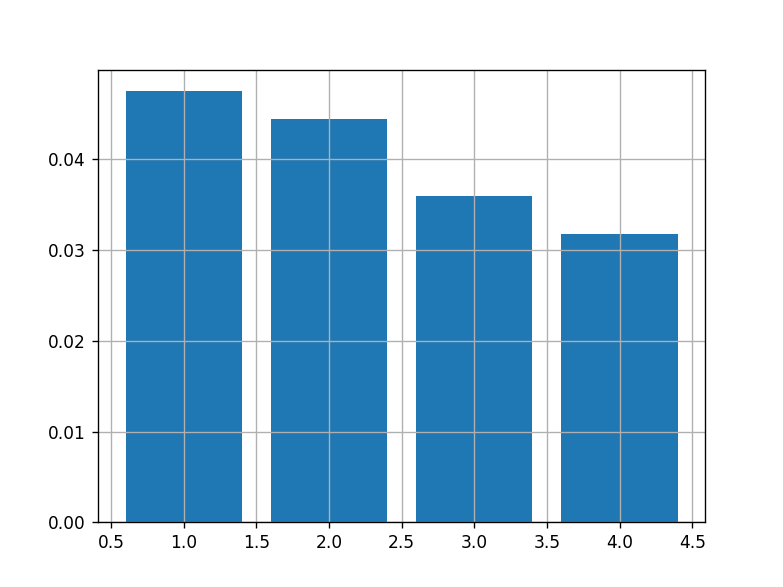

<IPython.core.display.Javascript object>


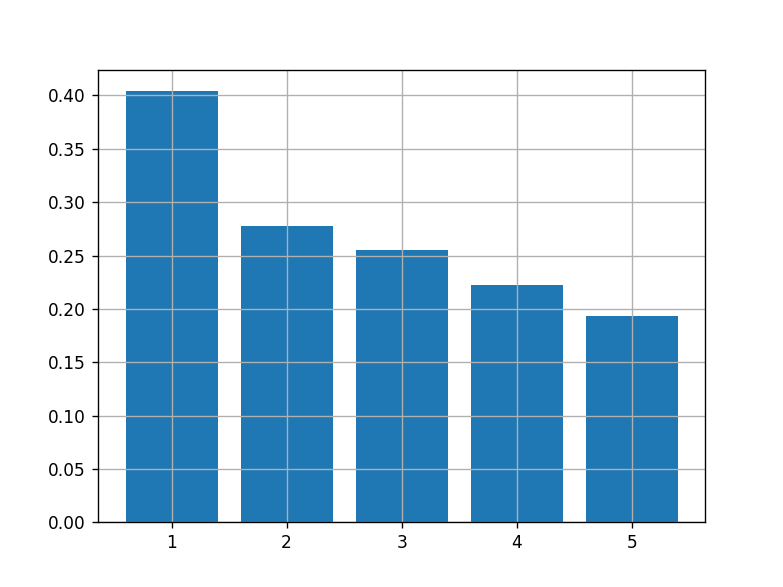

In [22]:

plt.figure()
Temp = fco2.Records.loc[(fco2.Records['Model']=='PPFD_Avg')|
                       (fco2.Records['Model']=='PPFD_Avg+VPD')|
                       (fco2.Records['Model']=='PPFD_Avg+VPD+VWC')|
                       (fco2.Records['Model']=='PPFD_Avg+VPD+VWC+Shrub')]
plt.bar(Temp['Size'],Temp['MSE'])
plt.grid()

plt.figure()
Temp = fch4.Records.loc[(fch4.Records['Model']=='Sedge')|
                       (fch4.Records['Model']=='VWC+Sedge')|
                       (fch4.Records['Model']=='VWC+Sedge+Grass')|
                       (fch4.Records['Model']=='wind_speed+VWC+Sedge+Grass')|
                       (fch4.Records['Model']=='wind_speed+PPFD_Avg+VWC+Sedge+Grass')]
plt.bar(Temp['Size'],Temp['MSE'])
plt.grid()

# print

In [22]:
import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

T30 = fco2.RST.Master.copy()
T30['TA'] = T30['AirTC_Avg'].shift(-2)

T30 = T30.loc[((T30.index>'2016-07-10 23:30:00') & (T30.index<'2016-08-07 00:00:00'))]
T30['Rain_mm_Tot']=T30['Rain_mm_Tot'].fillna(0)*10
T30[['Sedge','Shrub','Grass','Upland']]=T30[['Sedge','Shrub','Grass','Upland']].interpolate()
forest = RandomForestRegressor(max_leaf_nodes= int(10),min_samples_leaf=30)
Vars = ['TA','AirTC_Avg','NR_Wm2_Max','wind_speed','Rain_mm_Tot','VPD','DOY','DOY2','Temp','VWC']
test = T30.loc[T30['DOY']<200,Vars].dropna()
Key = Vars[0:5]
forest=LinearRegression().fit(test[Key],test['Temp'])
T30[Key]=T30[Key].ffill().bfill()
T30['TempFIll'] = forest.predict(T30[Key])
test = T30[['TempFIll','Temp','AirTC_Avg']].dropna()
# print(metrics.r2_score(test['Temp'],test['TempFIll']))
T30['Temp']=T30['Temp'].fillna(T30['TempFIll'])
test = T30[Vars].dropna()
Key=['DOY','DOY2','Temp','Rain_mm_Tot']
forest = LinearRegression().fit(test[Key],test['VWC'])
T30[Key]=T30[Key].ffill().bfill()
T30['TempFIll'] = forest.predict(T30[Key])
test = T30[['TempFIll','VWC',]].dropna()
# print(metrics.r2_score(test['VWC'],test['TempFIll']))
T30['VWC']=T30['VWC'].fillna(T30['TempFIll'])


T30_Dark = T30.copy()
T30_Dark['PPFD_Avg']=T30['PPFD_Avg'].min()

T30_Fixed = T30.copy()
FPRatios = {'Sedge':.122,
            'Sparse':.085,
            'Shrub':.602,
            'Grass':.159,
            'Upland':0.0,
            'Out_of_Basin':0.0
}

for var in ['Sedge','Sparse','Shrub','Grass','Upland']:
    T30_Fixed[var] = FPRatios[var]

    
T30_Dark_Fixed = T30_Fixed.copy()
T30_Dark_Fixed['PPFD_Avg']=T30['PPFD_Avg'].min()


def Kitty(AllData,target,target_name,DarkTarget=None):
    target.Project(Projector = None,
                Model = None)
    if DarkTarget is None:
        target.RST.Data = AllData
    else:
        target.RST.Data = DarkTarget
    target.RST.Scale(target.params['target'],
                   target.params['Inputs'],
                   ScalePath=target.params['Spath'],
                   Project=True)
    target.Map()
    AllData[target_name] = target.Data_Map[target.target].values
    AllData[target_name+'_Var_reg'] = target.Data_Map['Var_reg'].values
    AllData[target_name+'_Var_er'] = target.Data_Map['Var_er'].values
    AllData[target_name+'_CI'] = target.Data_Map['CI'].values
    AllData[target_name+'_PI'] = target.Data_Map['PI'].values
    return(AllData)

T30 = Kitty(T30,fco2_final,'ER_fixed_est',T30_Dark_Fixed)
T30 = Kitty(T30,fco2,'ER_est',T30_Dark)
T30 = Kitty(T30,fco2_final,'NEE_fixed_est',T30_Fixed)#,T30_Fixed)
T30 = Kitty(T30,fco2,'NEE_est')#,T30_Fixed)
T30 = Kitty(T30,fch4_final,'NME_fixed_est',T30_Fixed)#,T30_Fixed)
T30 = Kitty(T30,fch4,'NME_est')#,T30_Fixed)
# T30 = Kitty(T30,fch4_final,'NME_est',T30_Fixed)
# T30['GPP_est'] = T30['NEE_est']-T30['ER_est']


<IPython.core.display.Javascript object>


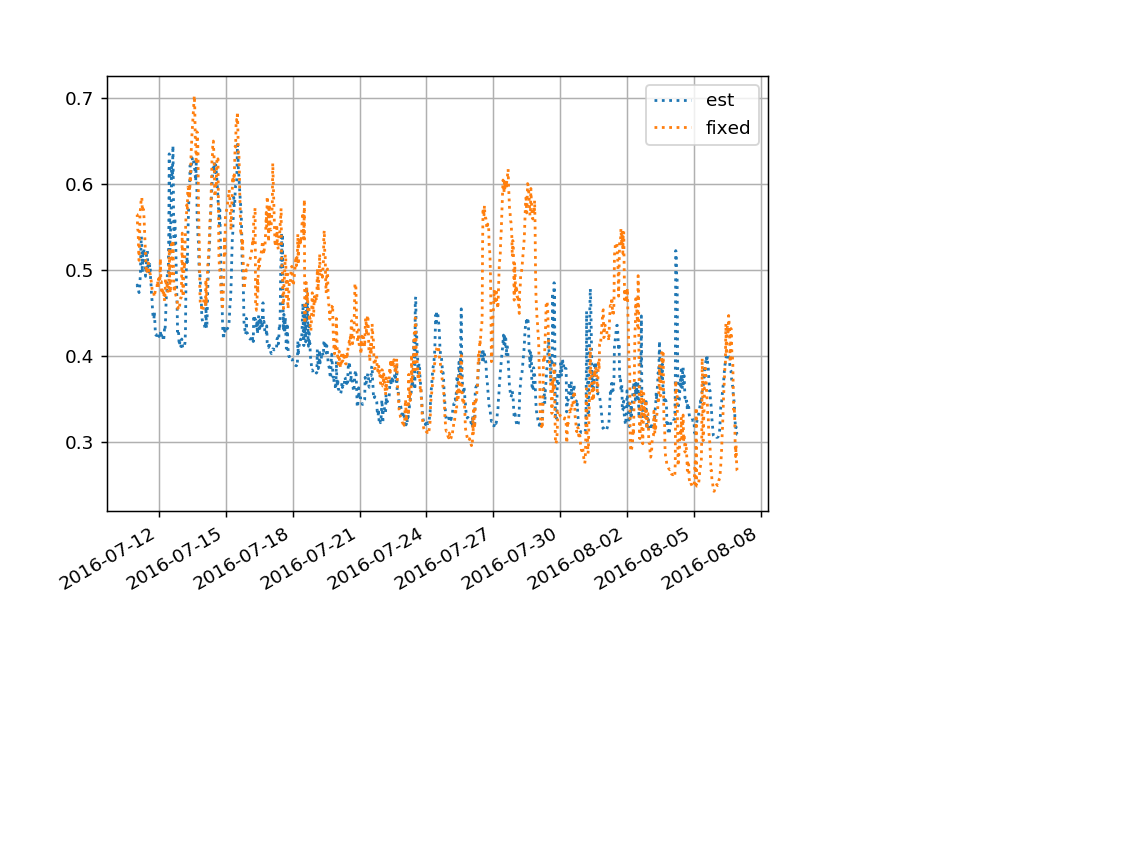

NEE_est_Var_reg         0.002713
NEE_fixed_est_Var_er    0.041000
dtype: float32


In [171]:
# fig = plt.figure()
# plt.scatter(T30_Dark_Fixed['Upland'],T30_Fixed['Upland'])
fig = plt.figure()
# plt.plot(T30['NEE_est'])
plt.plot(#T30['NEE_est']+
         (T30['NEE_est_Var_er']+T30['NEE_est_Var_reg'])**.5*fco2.T,linestyle=':',label='est')
plt.plot(#T30['NEE_est']-
         (T30['NEE_fixed_est_Var_er']+T30['NEE_fixed_est_Var_reg'])**.5*fco2.T,linestyle=':',label='fixed')
plt.legend()
plt.grid()
fig.autofmt_xdate()

print(T30[['NEE_est_Var_reg','NEE_fixed_est_Var_er']].mean())
# plt.scatter(T30['ER_est'],T30['VPD'])
# fig = plt.figure()
# plt.scatter(T30['ER_est'],T30['AirTC_Avg'])
# fig = plt.figure()
# plt.scatter(T30['ER_est'],T30['PPFD_Avg'])
# print(T30.loc[T30['ER_est']<0,['VPD','AirTC_Avg','wind_speed','PPFD_Avg']].min())
# print(T30.loc[T30['ER_est']<0,['VPD','AirTC_Avg','wind_speed','PPFD_Avg']].mean())
# print(T30.loc[T30['ER_est']<0,['VPD','AirTC_Avg','wind_speed','PPFD_Avg']].max())

In [220]:
def PooledVar_interval(T30,Vars,target,mean):
    n = target.params['K']
    T30['Pooled_Var']=T30[Vars].sum(axis=1)
    Sp = (n-1)*T30['Pooled_Var'].sum()/((n-1)*T30.shape[0])
#     Term1 = T30['Pooled_Var'].mean()
#     df1 = pd.DataFrame((np.subtract.outer(T30[mean], T30[mean]))**2*n*n, T30.index, T30.index)
#     Term2 = (df1.stack().sum()/((T30[mean].shape[0]*n)**2))
#     Sp = Term1+Term2
    return(Sp)

def Pooledstd_interval(T30,Vars,target,mean):
    n = target.params['K']
    T30['Pooled_Var']=T30[Vars].sum(axis=1)
    Term1 = T30['Pooled_Var'].mean()
    df1 = pd.DataFrame((np.subtract.outer(T30[mean], T30[mean]))**2*n*n, T30.index, T30.index)
    Term2 = (df1.stack().sum()/((T30[mean].shape[0]*n)**2))
    Sp = Term1+Term2
    return(Sp)

T30['NEE'] = T30['fco2'].fillna(T30['NEE_est'])
T30['NME'] = T30['fch4'].fillna(T30['NME_est'])

T30['GPP_est'] = T30['NEE_est']-T30['ER_est']
T30['GPP_fixed_est'] = T30['NEE_fixed_est']-T30['ER_fixed_est']

#

In [254]:
PooledVar_interval = Pooledstd_interval

('NEE')
print('Mean: ',T30['NEE'].mean()*mult)
print('CI: ',T30['NEE'].std()/(T30['NEE'].count()**.5) *stats.t.ppf(1-.025,T30['NEE'].count())*mult)
print('Var: ',T30['NEE'].std()**2)

print()
print('NEE_est')
print('Mean: ',T30['NEE_est'].mean()*mult)
pooled_std = PooledVar_interval(T30,
            ['NEE_est_Var_reg','NEE_est_Var_er'],fco2_final,'NEE_est')**.5
print('PI:  ',pooled_std*(1/T30.shape[0]+1/T30.shape[0])**.5*stats.t.ppf(1-.025,T30['NEE'].count())*mult)
print('Std: ',pooled_std)
pooled_std = PooledVar_interval(T30,['NEE_est_Var_reg'],fco2_final,'NEE_est')**.5
print('CI:  ',pooled_std/T30.shape[0]**.5*stats.t.ppf(1-.025,T30['NEE'].count())*mult)
print()

print('NEE_fixed_est')
print('Mean: ',T30['NEE_fixed_est'].mean()*mult)
pooled_std = PooledVar_interval(T30,
            ['NEE_fixed_est_Var_reg','NEE_fixed_est_Var_er'],fco2_final,'NEE_fixed_est')**.5
print('PI:  ',pooled_std*(1/T30.shape[0]+1/T30.shape[0])**.5*stats.t.ppf(1-.025,T30['NEE'].count())*mult)
pooled_std = PooledVar_interval(T30,['NEE_fixed_est_Var_reg'],fco2_final,'NEE_fixed_est')**.5
print('CI:  ',pooled_std/T30.shape[0]**.5*stats.t.ppf(1-.025,T30['NEE'].count())*mult)
print()

Mean:  -5.661678726063272
CI:  0.6805091008576243
Var:  0.2707339064965591

NEE_est
Mean:  -5.621531009674072
PI:   1.3498834435722322
Std:  0.7298248726397802
CI:   0.9219166355934149

NEE_fixed_est
Mean:  -4.984133005142212
PI:   1.3253514919834215
CI:   0.8989703956036736



In [255]:
print('NME')
print('Mean: ',T30['NME'].mean()*mult)
print('CI: ',T30['NME'].std()/(T30['NME'].count()**.5) *stats.t.ppf(1-.025,T30['NME'].count())*mult)
print('Var: ',T30['NME'].std()**2)

print()
print('NME_est')
print('Mean: ',T30['NME_est'].mean()*mult)
pooled_std = PooledVar_interval(T30,
            ['NME_est_Var_reg','NME_est_Var_er'],fco2_final,'NME_est')**.5
print('PI:  ',pooled_std*(1/T30.shape[0]+1/T30.shape[0])**.5*stats.t.ppf(1-.025,T30['NME'].count())*mult)
pooled_std = PooledVar_interval(T30,['NME_est_Var_reg'],fco2_final,'NME_est')**.5
print('CI:  ',pooled_std/T30.shape[0]**.5*stats.t.ppf(1-.025,T30['NME'].count())*mult)
print()

print('NME_fixed_est')
print('Mean: ',T30['NME_fixed_est'].mean()*mult)
pooled_std = PooledVar_interval(T30,
            ['NME_fixed_est_Var_reg','NME_fixed_est_Var_er'],fco2_final,'NME_fixed_est')**.5
print('PI:  ',pooled_std*(1/T30.shape[0]+1/T30.shape[0])**.5*stats.t.ppf(1-.025,T30['NME'].count())*mult)
pooled_std = PooledVar_interval(T30,['NME_fixed_est_Var_reg'],fco2_final,'NME_fixed_est')**.5
print('CI:  ',pooled_std/T30.shape[0]**.5*stats.t.ppf(1-.025,T30['NME'].count())*mult)
print()

NME
Mean:  12.537081111512649
CI:  0.8350532817967866
Var:  0.4076647391313114

NME_est
Mean:  12.540018081665039
PI:   1.5956102886589576
CI:   0.9629344659743526

NME_fixed_est
Mean:  11.475314855575562
PI:   1.2080568265842802
CI:   0.7068807666451942



In [260]:
print()
print('ER_est')
print('Mean: ',T30['ER_est'].mean()*mult)
pooled_std = PooledVar_interval(T30,
            ['ER_est_Var_reg','ER_est_Var_er'],fco2_final,'ER_est')**.5
print('PI:  ',pooled_std*(1/T30.shape[0]+1/T30.shape[0])**.5*stats.t.ppf(1-.025,T30['ER'].count())*mult)
pooled_std = PooledVar_interval(T30,['ER_est_Var_reg'],fco2_final,'ER_est')**.5
print(pooled_std*(1/T30.shape[0]+1/T30.shape[0])**.5)
print(1/T30.shape[0]+1/T30.shape[0])**.5)
print('CI:  ',pooled_std/(T30.shape[0]**.5)*stats.t.ppf(1-.025,T30['ER'].count())*mult)
print()

print('ER_fixed_est')
print('Mean: ',T30['ER_fixed_est'].mean()*mult)
pooled_std = PooledVar_interval(T30,
            ['ER_fixed_est_Var_reg','ER_fixed_est_Var_er'],fco2_final,'ER_fixed_est')**.5
print('PI:  ',pooled_std*(1/T30.shape[0]+1/T30.shape[0])**.5*stats.t.ppf(1-.025,T30['ER'].count())*mult)
pooled_std = PooledVar_interval(T30,['ER_fixed_est_Var_reg'],fco2_final,'ER_fixed_est')**.5
print('CI:  ',pooled_std/(T30.shape[0]**.5)*stats.t.ppf(1-.025,T30['ER'].count())*mult)
print()


ER_est
Mean:  8.602478742599487
PI:   0.44254922817520514
0.0063643747612746665
CI:   0.21439224268793416

ER_fixed_est
Mean:  8.547910451889038
PI:   0.4617046934847964
CI:   0.20601715868133602



In [257]:
print('Cbal', T30['NEE'].mean()*mult+T30['NME'].mean()*mult*1e-3*28)

Cbal -5.310640454940918


In [261]:
# Var = 'Shrub'
# print(T30[Var].min())
# print(T30[Var].quantile(.5))
# print(T30[Var].mean())
# print(T30[Var].quantile(.95))
# print(T30[Var].max())

H1 = T30.resample('D').mean()
H1s = T30.resample('D').std()
for v in ['ER_est_','ER_fixed_est_','NEE_est_','NEE_fixed_est_','NME_est_','NME_fixed_est_']:
    H1[v+'Pooled_CI'] = 0
    for day in H1.index:
        Samp = T30.loc[(T30.index>=day)&(T30.index<day+datetime.timedelta(days=1))]
        pooled_std = PooledVar_interval(Samp,
                [v+'Var_reg',v+'Var_er'],fco2_final,'ER_est')**.5
#         print()
#         print(pooled_std)
#         print(Samp[[v+'Var_reg',v+'Var_er']].sum(axis=1).mean()**.5)
        H1.loc[H1.index==day,v+'Pooled_CI']=pooled_std/(Samp.shape[0]**.5)*stats.t.ppf(1-.025,Samp.shape[0])
        H1.loc[H1.index==day,v+'Pooled_PI']=pooled_std*((1/Samp.shape[0]+1/T30.shape[0])**.5)*stats.t.ppf(1-.025,Samp.shape[0])

# plt.figure()
# plt.plot(H1['ER_est_Pooled_CI'])

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


<IPython.core.display.Javascript object>


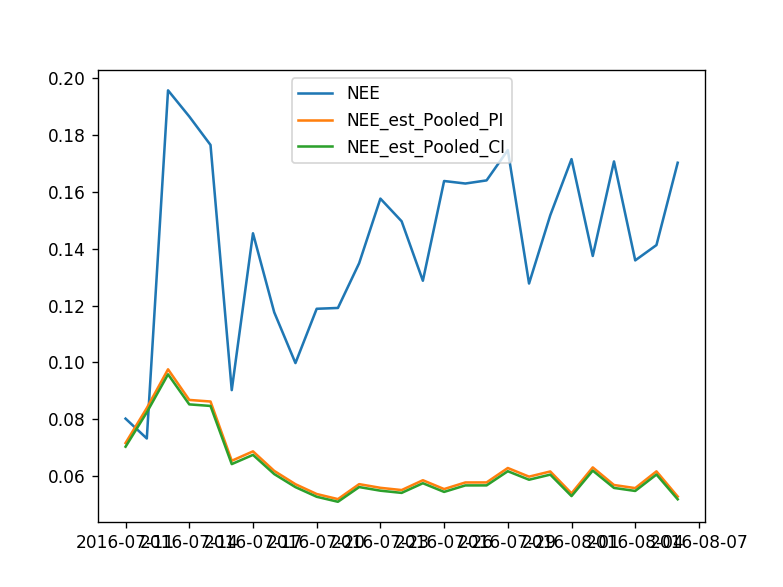

In [262]:
plt.figure()
plt.plot(H1s['NEE']/(48**.5)*stats.t.ppf(1-.025,48))
plt.plot(H1['NEE_est_Pooled_PI'])
plt.plot(H1['NEE_est_Pooled_CI'])
# plt.plot(T30['NEE'])
# plt.plot(T30['NEE_est'])#_Pooled_CI'])
plt.legend()

<IPython.core.display.Javascript object>


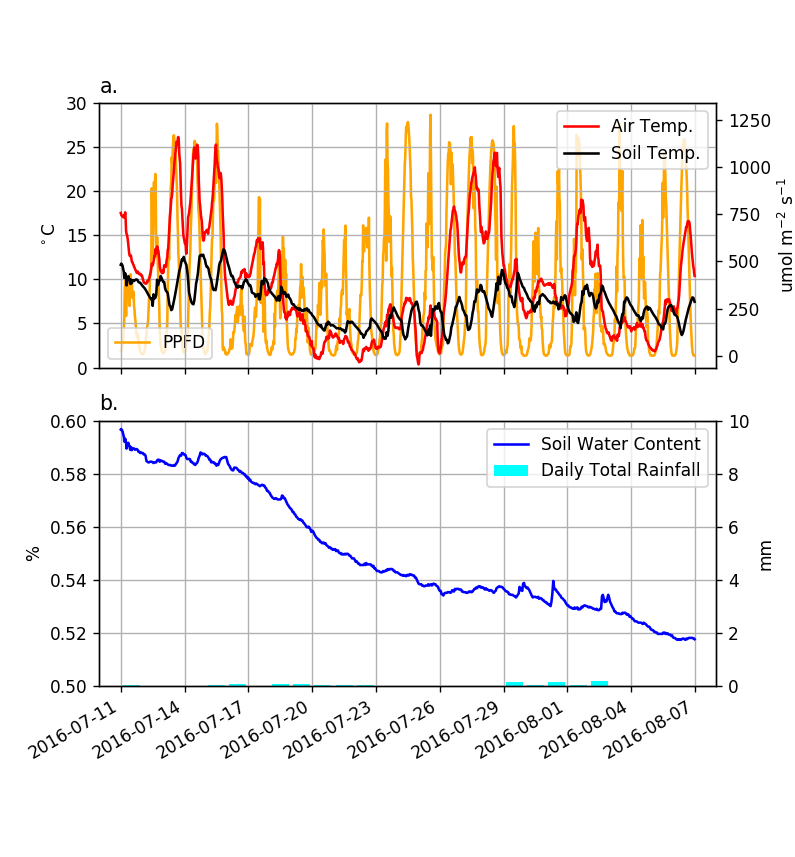

<IPython.core.display.Javascript object>


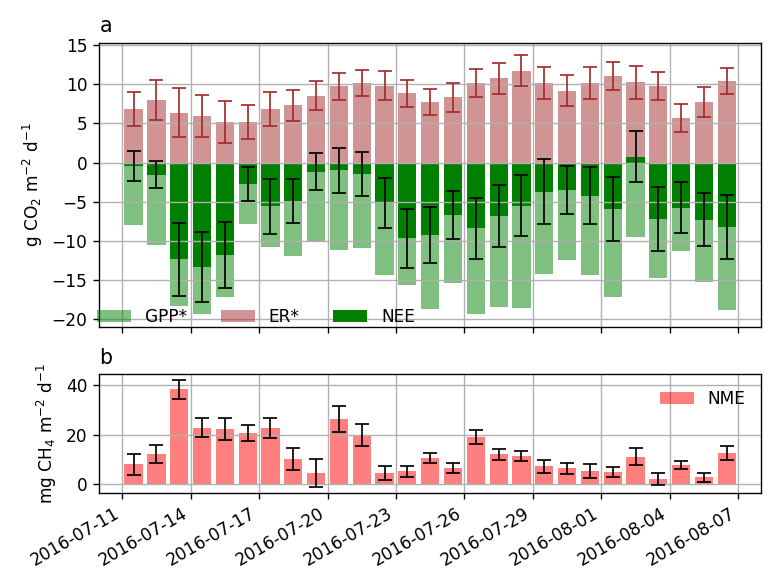

In [252]:



fig,ax = plt.subplots(2,1,figsize = (6.5,7),sharex=True)
ax[0].plot(T30['AirTC_Avg'],color='red',label = 'Air Temp.')
ax[0].plot(T30['Temp'],color='black',label = 'Soil Temp.')
ax[0].set_ylim(0,30)
yax2 = ax[0].twinx()
yax2.plot(T30['PPFD_Avg'],color='orange',label='PPFD')

ax[0].grid()
ax[0].set_zorder(ax[0].get_zorder()+1)
ax[0].patch.set_visible(False)

yax2.set_ylabel('umol m$^{-2}$ s$^{-1}$')
ax[0].set_ylabel('$^\circ$C')
ax[0].legend()
yax2.legend(loc=3)
ax[0].set_title('a.',loc='left')

yax2 = ax[1].twinx()
yax2.bar(H1.index+datetime.timedelta(hours=12),H1['Rain_mm_Tot'],color='cyan',label = 'Daily Total Rainfall')
yax2.set_ylim(0,10)

ax[1].plot(T30['VWC'],color='blue',label = 'Soil Water Content')
ax[1].bar(H1.index,H1['Rain_mm_Tot']*np.nan,color='cyan',label = 'Daily Total Rainfall')
ax[1].set_ylim(.50,.6)
ax[1].grid()
ax[1].set_zorder(ax[1].get_zorder()+1)
ax[1].patch.set_visible(False)
yax2.set_ylabel('mm')
ax[1].set_ylabel('%')
ax[1].legend()
ax[1].set_xlim([datetime.date(2016, 7, 10), datetime.date(2016, 8, 8)])
ax[1].set_title('b.',loc='left')
fig.autofmt_xdate()
plt.savefig('C:\\Users\\wesle\\Dropbox\\Illisarvik Manuscript/Fig2.png',dpi=300)


fig = plt.figure()
ax0 = plt.subplot2grid((3, 3), (0, 0), rowspan=2,colspan=3)
ax1 = plt.subplot2grid((3, 3), (2, 0), rowspan=1,colspan=3)
ax=[ax0,ax1]

mult = 24
ax[0].bar(H1.index+datetime.timedelta(hours=12),H1['GPP_est']*mult,
          color='green',
          label='GPP*',
#           yerr = H1['ER_est_Pooled_CI'],#*mult,
#           error_kw=dict(ecolor='green', lw=1, capsize=4, capthick=1),
          alpha=.5)
ax[0].bar(H1.index+datetime.timedelta(hours=12),H1['ER_est']*mult,
          yerr = H1['ER_est_Pooled_PI']*mult,
          error_kw=dict(ecolor='brown', lw=1, capsize=4, capthick=1),
          color='brown',label='ER*',alpha=.5)
ax[0].bar(H1.index+datetime.timedelta(hours=12),H1['NEE']*mult,
#           yerr = H1['NEE_est_Pooled_CI']*mult,#/(48**.5)*stats.t.ppf(1-.025,48),#*mult,
          yerr = H1s['NEE']/(48**.5)*stats.t.ppf(1-.025,48)*mult,
          color='green',
          error_kw=dict(ecolor='black', lw=1, capsize=4, capthick=1),
          label='NEE')

ax[0].grid()
ax[0].set_title('a',loc='left')
ax[0].set_ylabel('g CO${_2} $ m$^{-2}$ d$^{-1}$')
ax[0].legend(bbox_to_anchor=(0, -.052, 0.5, .1),
             facecolor='None',
             edgecolor='None',
             ncol=3,loc=4)

ax[0].set_xticklabels([])
ax[1].bar(H1.index+datetime.timedelta(hours=12),H1['NME']*mult,
          yerr = H1['NME_est_Pooled_CI']*mult,
#           yerr = H1s['NME']/(48**.5)*stats.t.ppf(1-.025,48)*mult,
          color='red',
          error_kw=dict(ecolor='black', lw=1, capsize=4, capthick=1),
          alpha=.5,
          label ='NME')
ax[1].grid()
ax[1].set_title('b',loc='left')
ax[1].set_ylabel('mg CH${_4} $ m$^{-2}$ d$^{-1}$')

ax[0].set_xlim([datetime.date(2016, 7, 10), datetime.date(2016, 8, 8)])
ax[1].set_xlim([datetime.date(2016, 7, 10), datetime.date(2016, 8, 8)])
ax[1].legend(facecolor='None',
         edgecolor='None',)
fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('C:\\Users\\wesle\\Dropbox\\Illisarvik Manuscript/Fig3.png',dpi=300)


In [ ]:

def P_func(PPFD,MQY,PM):
    cv =.7
    return((MQY*PPFD + PM - ((MQY*PPFD + PM)**2 - 4*cv*MQY*PPFD*PM)**.5)/(2*cv))
def R_func(T,r1,r2,r3):
    return(1/(r1*r2**T+r3))
def R_func2(T,Q10,R10):
    return(R10*Q10**((T-10)/10))
Dark = T30.loc[T30['PPFD_Avg']<10,['Temp','fco2','ER_est','AirTC_Avg']].dropna()


# print(T30.loc[T30['PPFD_Avg']<10,['Temp','fco2']].drop)
popt_r, pcov = curve_fit(R_func, Dark['Temp'], Dark['fco2'],p0=( 4.59262144,0.5875255,0.27508822))
popt_r2, pcov2 = curve_fit(R_func2, Dark['AirTC_Avg'], Dark['fco2'])#,p0=( 4.59262144,0.5875255,0.27508822))

#p0=( 74.59262144,0.8875255,2.27508822))
plt.figure()
plt.scatter(Dark['fco2'],R_func(Dark['Temp'],*popt_r),c='red',
            label='Model '+str(np.round(metrics.mean_squared_error(Dark['fco2'],R_func(Dark['Temp'],*popt_r))**.5,3)))
plt.scatter(Dark['fco2'],R_func2(Dark['AirTC_Avg'],*popt_r2),c='pink',
            label='Model '+str(np.round(metrics.mean_squared_error(Dark['fco2'],R_func2(Dark['Temp'],*popt_r2))**.5,3)))
plt.scatter(Dark['fco2'],Dark['ER_est'],c='blue',
            label='NN '+str(np.round(metrics.mean_squared_error(Dark['fco2'],Dark['ER_est'])**.5,3)))
# plt.colorbar()
plt.plot([0,1],[0,1],label='1:1',color='black')
plt.ylabel('pred')
plt.xlabel('tru')
plt.legend()

plt.xlim(0,1)
plt.ylim(0,1)
plt.grid()
T30['ER2'] = R_func(T30['Temp'],*popt_r)
T30['ER3'] = R_func2(T30['AirTC_Avg'],*popt_r2)


P = T30[T30['PPFD_Avg']>=10]
P = P[['fco2','ER2','PPFD_Avg']].dropna()
popt_p, pcov = curve_fit(P_func, P['PPFD_Avg'], -1*(P['fco2']-P['ER2']),p0=(.01,10))
# T30['GPP2'] = Data['GPP'].fillna(P_func(Data['PPFD_Avg'],*popt_p))
T30['GPP2'] = -1*P_func(T30['PPFD_Avg'],*popt_p)
T30['NEE2'] = T30['GPP2']+T30['ER2']

# popt_p, pcov = curve_fit(P_func, P['PPFD_Avg'], P['fco2']-,p0=(.003,12))
# Data['GPP'] = Data['GPP'].fillna(P_func(Data['PPFD_Avg'],*popt_p))
# Data['GPP_fill'] = P_func(Data['PPFD_Avg'],*popt_p)



# T30['GPP'] = T30['NEE']-T30['ER_est']
# T30['GPP2'] = T30['NEE_est']-T30['ER2']
print('Mean ER:')
print(T30[['ER_est','ER2']].mean())
print(Dark['fco2'].mean())
print()
print('R2 Score:')
print('ER: ',metrics.r2_score(Dark['fco2'],Dark['ER_est']),
     'ER2: ',metrics.r2_score(Dark['fco2'],R_func(Dark['Temp'],*popt_r)))
print()
print('MSE:')
print('ER: ',metrics.mean_squared_error(Dark['fco2'],Dark['ER_est'])**.5,
     'ER2: ',metrics.mean_squared_error(Dark['fco2'],R_func(Dark['Temp'],*popt_r))**.5)
print(T30[['GPP_est','GPP2']].mean())
# print(T30.loc[T30['GPP_est']>0,'GPP_est'].count())
# print(T30.loc[T30['GPP2']>0,'GPP2'].count())
# print(T30.loc[T30['GPP_est']>0,'GPP_est'].mean())
# print(T30.loc[T30['GPP2']>0,'GPP2'].mean())
print(popt_r)
print(popt_p)
print(T30.loc[T30['ER_est']<.15,['ER_est','ER','fco2','PPFD_Avg','VPD','Shrub','VWC']].mean())
# print(T30.loc[T30['VPD']<=0,'RH'])

In [ ]:
plt.figure()
# plt.scatter(T30['PPFD_Avg'],T30['fco2'],c='red',edgecolor='black',alpha=.5,s=10)
Temp=T30[['NEE2','NEE_est','fco2']].dropna()
plt.plot([-1.9,1],[-1.9,1],color='black')
plt.scatter(T30['fco2'],T30['NEE2'],c='black',edgecolor='black',alpha=.5,s=10,
           label=str(np.round(metrics.r2_score(Temp['fco2'],Temp['NEE2']),2)))
plt.scatter(T30['fco2'],T30['NEE_est'],c='red',edgecolor='black',alpha=.5,s=10,
           label=str(np.round(metrics.r2_score(Temp['fco2'],Temp['NEE_est']),2)))
plt.grid()
plt.legend()
plt.xlabel('Observation')
plt.ylabel('Estimate')
plt.ylim(-1.9,1)
plt.xlim(-1.9,1)

fig=plt.figure()
plt.plot(T30['fco2'],color='black')
plt.plot(T30['NEE2'],color='green')
plt.plot(T30['NEE_est'],color='violet')
plt.grid()
plt.legend()
fig.autofmt_xdate()


In [ ]:
def Plot(ax,Label,Data,regressor,color,target,Interval='CI',linestyle='-'):
    Data = Data.sort_values(regressor)#.reset_index()
    try:
        Data['True']*=1
    except:
        Data['True']=0
        pass
    
    ax.plot(Data[regressor],Data[target],
            label= Label,
            linestyle=linestyle,
            color = color)   
#     ax.fill_between(Data[regressor],
#                     Data[target]-Data[Interval], 
#                     Data[target]+Data[Interval],
#                     facecolor='None',
#                     alpha = .5,
#                     edgecolor = color, 
#                     linestyle=':',
#                     linewidth=2,
# #                     label = '90% '+Interval
#                    )


In [ ]:

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

def QQ(target,Range,N,Mask={}):
    
    target.Project(Projector = None,Model = None)
    columns=[Range]
    l = 1
    for key in Mask.keys():
        columns.append(key)  
        l+=1
    for v in target.params['Inputs']:
        if v not in columns:
            columns.append(v)
    scaler = StandardScaler()
    scaler.fit(target.RST.Data[columns[l:]])
    Temp = scaler.transform(target.RST.Data[columns[l:]])
    Temp = pd.DataFrame(data = Temp,columns = columns[l:])
    kmeans = KMeans(n_clusters=N, random_state=0).fit(Temp)
    Q = scaler.inverse_transform(kmeans.cluster_centers_)
    columns.append('target')
    def Make(Data,columns,map_range,values,N=20,Mask=None):
        ranges = [np.linspace(map_range[0],map_range[1],N)]
        for key in Mask.keys():
            ranges.append(np.ones(N)*Mask[key])
        for v in values:
            ranges.append(np.ones(N)*v)
        ranges.append(np.ones(N)*0)
        data = {}
        for (col,ran) in zip(columns,ranges):
            data[col]=ran
        return(pd.DataFrame(data = data))
    tarList=[]
    for i,quantile in enumerate(Q):
        values = []
        for q in quantile:
            values.append(q)
        Data = Make(target.RST.Data,columns,
                    map_range=[target.RST.Data[columns[0]].min(),target.RST.Data[columns[0]].max()],
                    values=values,Mask=Mask)
        target.RST.Data=Data
        target.RST.Scale(target.RST.params['target'],target.RST.params['Inputs'],ScalePath=target.RST.params['Spath'],Project=True)
        target.Map()
        tarList.append(target.Data_Map)  
    return(tarList,Q,columns[l:-1])

colors = ['red','orange','yellow','green','blue','indigo','violet']
differential='Sedge'
target = fch4
fig,ax=plt.subplots(2,1,figsize=(7,10))
# for mask,line in zip([0,1000],['-',':']):
line = '-'

# tarList,means,columns=QQ(target,differential, len(colors))#,Mask={'PPFD_Avg':mask})
Kdata = pd.DataFrame(data=means,columns=columns)
print(Kdata)
i=0
for Data,color in zip(tarList,colors):
    Plot(ax[0],str([key+': '+str(val) for key, val in zip(columns,Kdata.iloc[i][columns].round(2))]),
         Data,differential,color,target.target,Interval = 'PI',linestyle=line)
    ax[1].plot(Data[differential],Data[target.target].diff()/Data[differential].diff(),
           linestyle = line,
           label = str([key+': '+str(val) for key, val in zip(columns,Kdata.iloc[i][columns].round(2))]),
           color = color)
    i += 1
ax[0].legend(fontsize=6,loc=2)
ax[0].grid()
ax[1].legend()
ax[1].grid()


In [ ]:
plt.figure()
plt.scatter(fco2.RST.Master['VPD'],fco2.RST.Master['PPFD_Avg'])#,color='color',label='Var_er')

In [ ]:
fch4.Project(Projector = None,Model = None)
fco2.Project(Projector = None,Model = None)
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(fco2.RST.Data[fco2.params['Inputs']],fco2.RST.Data[fco2.params['target']])


y_pred = reg.predict(fco2.RST.Data[fco2.params['Inputs']])
print(metrics.mean_squared_error(y_pred,fco2.RST.Data[fco2.params['target']]))
y_pred2 =  reg.predict(fco2.RST.Data[fco2.params['Inputs']])
# reg.coef_

# reg.intercept_ 

# reg.predict(np.array([[3, 5]]))
             
# print()
fco2.RST.Data['y_pred2']=y_pred2
plt.figure()
plt.scatter(fco2.RST.Data['PPFD_Avg'],fco2.RST.Data['y_pred2'])


# import CART_Backend as Tree

# tree = Tree.Trees(fco2.RST.Data,'fco2',params['Inputs'])
# tree.Validate(kind='Tree',N_Max=15,step_size=1,ax=ax,iteration=15,min_samples_leaf=10)


from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(max_leaf_nodes= int(10),min_samples_leaf=30)

forest.fit(fco2.RST.Data[fco2.params['Inputs']],fco2.RST.Data[fco2.params['target']])

y_pred = forest.predict(fco2.RST.Data[fco2.params['Inputs']])
y_pred3=forest.predict(fco2.RST.Data[fco2.params['Inputs']])
fco2.RST.Data['y_pred3']=y_pred3
plt.scatter(fco2.RST.Data['PPFD_Avg'],fco2.RST.Data['y_pred3'])
print(metrics.mean_squared_error(y_pred,fco2.RST.Data[fco2.params['target']]))